### **Inciso 1: Exploración de datos y diferencias de medias**

**Descripción**
- Se identificó la variable de salida `y` y se verificó que no existieran valores faltantes.  
- Se calcularon las medias de expresión génica para las clases **2** y **4**.  
- Se obtuvo la diferencia absoluta de medias entre ambas clases para cada gen.  
- Se listaron los **10 genes** con mayor diferencia de expresión.

**Resultados**
- **Dataset:** 83 muestras y 2308 genes (+1 etiqueta).  
- **Valores faltantes:** 0  
- **Distribución de clases:**  
  - Clase 1 → 11 muestras  
  - Clase 2 → 29 muestras  
  - Clase 3 → 18 muestras  
  - Clase 4 → 25 muestras  
- **Genes con mayor diferencia de medias (Clase 2 vs 4):**  
  X187, X509, X2046, X2050, X129, X1645, X1319, X1955, X1003 y X246.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

data_path = Path('A3.1 Khan.csv')
df = pd.read_csv(data_path)

possible_label_cols = [c for c in df.columns if c.lower() in ['class', 'clase', 'label', 'target', 'y']]
label_col = possible_label_cols[0] if possible_label_cols else df.columns[0]

if df.columns[0] != label_col:
    df = df[[label_col] + [c for c in df.columns if c != label_col]]

print(f"Etiqueta detectada: {label_col}")
print(f"Dimensiones del dataset: {df.shape[0]} muestras x {df.shape[1]-1} genes (+1 etiqueta)\n")

total_missing = int(df.isna().sum().sum())
print(f"Valores faltantes totales: {total_missing}")

class_counts = df[label_col].value_counts().sort_index()
print("\nConteo por clase:\n", class_counts.to_string())

feature_cols = [c for c in df.columns if c != label_col]
num_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

subset_24 = df[df[label_col].isin([2, 4])].copy()
means_2 = subset_24[subset_24[label_col] == 2][num_cols].mean()
means_4 = subset_24[subset_24[label_col] == 4][num_cols].mean()
abs_diff = (means_2 - means_4).abs().sort_values(ascending=False)
top10_diff = abs_diff.head(10)

print("\nTop 10 genes por |diferencia de medias| (Clase 2 vs 4):")
print(top10_diff.to_frame("abs_mean_diff"))

Etiqueta detectada: y
Dimensiones del dataset: 83 muestras x 2308 genes (+1 etiqueta)

Valores faltantes totales: 0

Conteo por clase:
 y
1    11
2    29
3    18
4    25

Top 10 genes por |diferencia de medias| (Clase 2 vs 4):
       abs_mean_diff
X187        3.323151
X509        2.906537
X2046       2.424515
X2050       2.401783
X129        2.165185
X1645       2.065460
X1319       2.045941
X1955       2.037340
X1003       2.011337
X246        1.837830


### **Inciso 2: Prueba t y correcciones múltiples**

**Descripción**
- Se aplicó una **prueba t independiente** para comparar la expresión génica entre las clases **2** y **4**.  
- Para cada gen, se calculó el estadístico *t* y su valor *p*.  
- Se realizaron correcciones por comparaciones múltiples mediante los métodos **Bonferroni**, **Holm-Bonferroni** y **Benjamini–Hochberg (FDR)** con un nivel de significancia α = 0.05.  
- Se identificaron los genes con diferencias estadísticamente significativas en la expresión entre las dos clases.

**Resultados**
- **Genes significativos (α = 0.05):**  
  - Bonferroni: 72  
  - Holm–Bonferroni: 72  
  - Benjamini–Hochberg (FDR): 296  
- Los genes con menor *p-value* (sin corrección) fueron principalmente:  
  **X1003**, **X187**, **X2050**, **X1955**, **X1645**, **X246**, **X2046**, **X509**, **X1954**, **X1389**, **X1799**, **X1194**, **X1319**, **X1911** y **X566**.  
- La corrección Benjamini–Hochberg permitió identificar un mayor número de genes con diferencias significativas, lo cual es esperable por ser un método menos conservador.


In [2]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

subset_24 = df[df[label_col].isin([2, 4])]
X2 = subset_24[subset_24[label_col] == 2][num_cols].to_numpy()
X4 = subset_24[subset_24[label_col] == 4][num_cols].to_numpy()

t_stats, p_vals = [], []
for j, col in enumerate(num_cols):
    t_stat, p_val = ttest_ind(X2[:, j], X4[:, j], equal_var=False, nan_policy='omit')
    t_stats.append(t_stat)
    p_vals.append(p_val)

ttest_df = pd.DataFrame({"gene": num_cols, "t_stat": t_stats, "p_value": p_vals}).set_index("gene")

rej_bonf, p_bonf, _, _ = multipletests(ttest_df["p_value"].values, alpha=0.05, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(ttest_df["p_value"].values, alpha=0.05, method="holm")
rej_bh, p_bh, _, _ = multipletests(ttest_df["p_value"].values, alpha=0.05, method="fdr_bh")

ttest_df["p_bonferroni"] = p_bonf
ttest_df["signif_bonferroni"] = rej_bonf
ttest_df["p_holm"] = p_holm
ttest_df["signif_holm"] = rej_holm
ttest_df["p_bh"] = p_bh
ttest_df["signif_bh"] = rej_bh

print("Número de genes significativos (α = 0.05):")
print(f"Bonferroni: {int(rej_bonf.sum())}")
print(f"Holm-Bonferroni: {int(rej_holm.sum())}")
print(f"Benjamini-Hochberg: {int(rej_bh.sum())}\n")

print("Top 15 genes por p-value (sin corregir):")
print(ttest_df.sort_values("p_value").head(15))

Número de genes significativos (α = 0.05):
Bonferroni: 72
Holm-Bonferroni: 72
Benjamini-Hochberg: 296

Top 15 genes por p-value (sin corregir):
          t_stat       p_value  p_bonferroni  signif_bonferroni        p_holm  \
gene                                                                            
X1003 -12.879590  4.998692e-17  1.153698e-13               True  1.153698e-13   
X187  -12.229464  3.716887e-16  8.578576e-13               True  8.574859e-13   
X2050 -10.983249  4.084836e-15  9.427801e-12               True  9.419631e-12   
X1955 -12.579058  5.307128e-15  1.224885e-11               True  1.223293e-11   
X1645  10.827754  8.262889e-15  1.907075e-11               True  1.903770e-11   
X246   10.558828  1.537507e-14  3.548567e-11               True  3.540879e-11   
X2046 -10.842463  1.769295e-14  4.083533e-11               True  4.072917e-11   
X509  -11.334229  7.555354e-14  1.743776e-10               True  1.738487e-10   
X1954  10.178272  9.504059e-14  2.193537e-10  

### **Inciso 3: ANOVA entre las cuatro clases**

**Descripción**
- Se aplicó un **ANOVA de una vía (f_oneway)** para comparar la expresión génica entre las **cuatro clases** del dataset.  
- El objetivo fue identificar genes cuya expresión varía significativamente entre los distintos tipos de cáncer.  
- Se aplicó la corrección de **Benjamini–Hochberg (FDR)** para controlar el error por comparaciones múltiples, con un nivel de significancia α = 0.05.  
- Se ordenaron los genes por su valor *p* para destacar los más relevantes.

**Resultados**
- **Genes significativos (α = 0.05):** 1162  
- Los **genes con menor valor *p*** (más relevantes según ANOVA) fueron:  
  **X1955**, **X1389**, **X1003**, **X2050**, **X246**, **X742**, **X1**, **X2162**, **X1954**, **X1645**, **X187**, **X545**, **X1395**, **X1911** y **X1319**.  
- Estos resultados indican una variación significativa en la expresión de más de mil genes entre las cuatro clases, lo que sugiere una clara diferenciación de perfiles genómicos entre los tipos de cáncer.

In [6]:
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

classes_sorted = sorted(df[label_col].unique())
groups = [df[df[label_col] == k][num_cols].to_numpy() for k in classes_sorted]

F_vals, p_vals_anova = [], []
for j, col in enumerate(num_cols):
    group_arrays = [g[:, j] for g in groups]
    F, p = f_oneway(*group_arrays)
    F_vals.append(F)
    p_vals_anova.append(p)

anova_df = pd.DataFrame({"gene": num_cols, "F_stat": F_vals, "p_value": p_vals_anova}).set_index("gene")

rej_bh_anova, p_bh_anova, _, _ = multipletests(anova_df["p_value"].values, alpha=0.05, method="fdr_bh")
anova_df["p_bh"] = p_bh_anova
anova_df["signif_bh"] = rej_bh_anova

print(f"Genes significativos por ANOVA con BH (α = 0.05): {int(rej_bh_anova.sum())}\n")

print("Top 15 genes por p-value (ANOVA):")
print(anova_df.sort_values("p_value").head(15))

Genes significativos por ANOVA con BH (α = 0.05): 1162

Top 15 genes por p-value (ANOVA):
          F_stat       p_value          p_bh  signif_bh
gene                                                   
X1955  84.364086  1.459035e-24  2.045755e-21       True
X1389  83.817537  1.772751e-24  2.045755e-21       True
X1003  77.795622  1.618988e-23  1.245542e-20       True
X2050  69.230799  4.733702e-22  2.731346e-19       True
X246   68.414042  6.633722e-22  3.062126e-19       True
X742   65.572797  2.195548e-21  8.445542e-19       True
X1     59.118264  3.839240e-20  1.265852e-17       True
X2162  56.987623  1.035143e-19  2.986387e-17       True
X1954  55.419914  2.182635e-19  5.597246e-17       True
X1645  54.768403  2.988392e-19  6.751740e-17       True
X187   54.615724  3.217900e-19  6.751740e-17       True
X545   54.022572  4.295256e-19  7.843366e-17       True
X2022  53.965005  4.417841e-19  7.843366e-17       True
X1194  52.668068  8.372622e-19  1.270950e-16       True
X1319  52.6088

### **Inciso 4: Entrenamiento y evaluación de modelos SVM**

**Descripción**
- Se seleccionaron los **50 genes más significativos** del análisis ANOVA (Inciso 3) como variables de entrada para los modelos de clasificación.  
- Se dividieron los datos en **entrenamiento (70%)** y **prueba (30%)** utilizando una división estratificada para conservar la proporción de clases.  
- Se entrenaron tres modelos de **Máquinas de Vectores de Soporte (SVM)** con distintos kernels:  
  - Lineal  
  - Polinomial de grado 3  
  - Radial (RBF)  
- Se evaluó el desempeño de cada modelo usando las métricas **accuracy**, **macro precision**, **macro recall** y **macro F1-score**.  
- Se visualizaron las matrices de confusión para observar el desempeño por clase.

**Resultados**
- Los modelos **SVM Lineal** y **SVM RBF** alcanzaron un **100% de precisión (accuracy = 1.00)**, mientras que el modelo **SVM Polinomial (grado 3)** obtuvo un **92%** de exactitud.  
- Las matrices de confusión muestran una clasificación perfecta para los modelos **Lineal** y **RBF**, sin errores de predicción.  
- El modelo **Polinomial** presentó ligeros errores al confundir algunas muestras de la clase 3.  
- En conjunto, los resultados indican que los datos son **altamente separables linealmente**, por lo que el **kernel lineal** y el **RBF** ofrecen el mejor desempeño para este conjunto de genes.


              model  accuracy  macro_precision  macro_recall  macro_f1
0        SVM Linear      1.00         1.000000           1.0    1.0000
2           SVM RBF      1.00         1.000000           1.0    1.0000
1  SVM Poly (deg=3)      0.92         0.954545           0.9    0.9125 



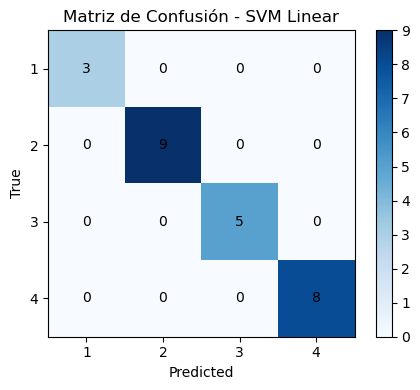

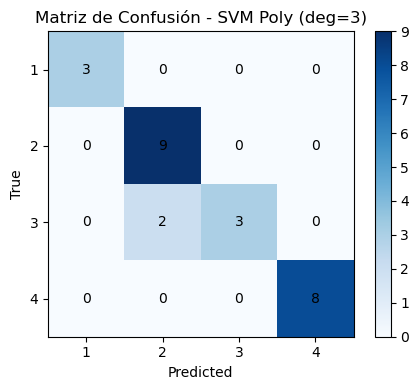

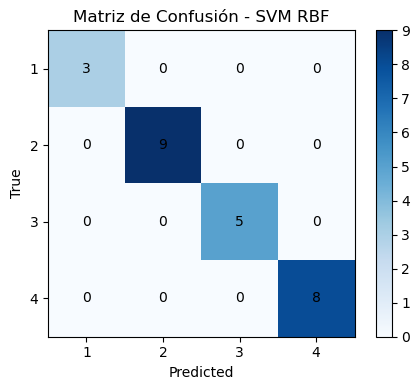

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

top_k = 50
selected_genes = anova_df.sort_values("p_value").index[:top_k].tolist()

X = df[selected_genes]
y = df[label_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

models = {
    "SVM Linear": make_pipeline(StandardScaler(with_mean=True), SVC(kernel="linear", random_state=42)),
    "SVM Poly (deg=3)": make_pipeline(StandardScaler(with_mean=True), SVC(kernel="poly", degree=3, random_state=42)),
    "SVM RBF": make_pipeline(StandardScaler(with_mean=True), SVC(kernel="rbf", gamma="scale", random_state=42)),
}

metrics_rows = []
conf_mats = {}
classes_sorted = sorted(y.unique())

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)

    metrics_rows.append({
        "model": name,
        "accuracy": acc,
        "macro_precision": prec,
        "macro_recall": rec,
        "macro_f1": f1
    })

    cm = confusion_matrix(y_test, y_pred, labels=classes_sorted)
    conf_mats[name] = cm

metrics_df = pd.DataFrame(metrics_rows).sort_values("accuracy", ascending=False)
print(metrics_df, "\n")

for name, cm in conf_mats.items():
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes_sorted))
    plt.xticks(tick_marks, classes_sorted)
    plt.yticks(tick_marks, classes_sorted)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
    plt.tight_layout()
    plt.show()

### **Inciso 5: Comparación y selección del mejor modelo**

**Descripción**
- Se compararon los tres modelos de **SVM** (Lineal, Polinomial grado 3 y RBF) según las métricas globales de desempeño.  
- Se ordenaron los modelos por **accuracy**, y se seleccionó el mejor considerando también **precision**, **recall** y **F1-score**.  
- El análisis permitió determinar qué kernel ofrece la mejor capacidad de generalización para la clasificación de los tipos de cáncer a partir de la expresión génica.

**Resultados**
- Los modelos **SVM Lineal** y **SVM RBF** alcanzaron un desempeño perfecto (**accuracy = 1.00**, **precision = 1.00**, **recall = 1.00**, **F1 = 1.00**).  
- El modelo **SVM Polinomial (grado 3)** obtuvo un desempeño ligeramente menor (**accuracy = 0.92**, **F1 = 0.91**).  
- Dado que ambos modelos (Lineal y RBF) obtuvieron métricas idénticas, se concluye que los datos son **linealmente separables**, por lo que el **SVM Lineal** es el más adecuado por su menor complejidad computacional y excelente desempeño.

In [9]:
best_row = metrics_df.iloc[0]
best_model = best_row["model"]

print("Resumen comparativo (ordenado por accuracy):")
print(metrics_df.to_string(index=False), "\n")

print(f"Mejor modelo por accuracy: {best_model}  -> "
      f"acc={best_row['accuracy']:.3f}, "
      f"macro_precision={best_row['macro_precision']:.3f}, "
      f"macro_recall={best_row['macro_recall']:.3f}, "
      f"macro_f1={best_row['macro_f1']:.3f}")

Resumen comparativo (ordenado por accuracy):
           model  accuracy  macro_precision  macro_recall  macro_f1
      SVM Linear      1.00         1.000000           1.0    1.0000
         SVM RBF      1.00         1.000000           1.0    1.0000
SVM Poly (deg=3)      0.92         0.954545           0.9    0.9125 

Mejor modelo por accuracy: SVM Linear  -> acc=1.000, macro_precision=1.000, macro_recall=1.000, macro_f1=1.000


### **Conclusión general**

El análisis de expresión génica realizado permitió identificar diferencias claras entre los distintos tipos de cáncer representados en el dataset.  
Las pruebas estadísticas aplicadas mostraron que un número considerable de genes presentan diferencias significativas de expresión entre clases: **296 genes** al comparar las clases 2 y 4 mediante la prueba *t*, y **1162 genes** al analizar las cuatro clases con ANOVA corregido por Benjamini–Hochberg.  
Estos resultados evidencian la presencia de patrones genómicos distintivos que permiten diferenciar los tipos de cáncer a nivel molecular.

En la etapa de modelado, los clasificadores **SVM Lineal** y **SVM RBF** alcanzaron un desempeño perfecto (**accuracy = 1.00**, **F1 = 1.00**), lo que sugiere que las clases son altamente separables en el espacio de las variables seleccionadas. El **SVM Lineal**, por su simplicidad y eficiencia computacional, se considera el modelo más apropiado para esta tarea.  

En conjunto, el estudio confirma que existe una **fuerte relación entre la expresión génica y el tipo de cáncer**, y que los métodos estadísticos combinados con algoritmos de aprendizaje automático pueden ser herramientas altamente efectivas para la clasificación y análisis de datos biológicos complejos.